#Частина 1
В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
! pip install livelossplot

In [ ]:
import livelossplot

In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers.legacy import SGD, Adam

In [ ]:
def define_model(opt_name: str = 'SGD', learning_rate: float = 0.01, n_conv: int = 1, n_drop: int = 0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    if n_conv == 1:
      model.add(MaxPooling2D((2, 2)))
    if n_conv > 1:
      model.add(Conv2D(64, (3, 3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))
      if n_drop > 0:
        model.add(Dropout(0.5))
    if n_conv > 2:
      model.add(Conv2D(128, (3, 3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))
      if n_drop > 1:
        model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    opt = opt_name.upper()
    if opt is None or opt == 'SGD':
        lr = 0.01 if learning_rate is None else learning_rate
        opt = SGD(learning_rate=lr, momentum=0.9)
    elif opt == 'ADAM':
        lr = 0.001 if learning_rate is None else learning_rate
        opt = Adam(learning_rate=lr)
    print(f'optimizer: {opt_name}, learning_rate: {learning_rate}')

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
label_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def display_some_examples(examples, labels, predicts=None, label_name=None):
    lab1 = tf.math.argmax(labels, axis=1).numpy()
    if predicts is not None:
      pred1 = tf.math.argmax(predicts, axis=1).numpy()

    pyplot.figure(figsize=(13,13))

    for i in range(15):

        idx = np.random.randint(0, examples.shape[0]-1)
        img = examples[idx]

        label = str(lab1[idx])
        if label_name is not None:
          label = f'{label} ({label_name[lab1[idx]]})'
        if predicts is not None:
          label = f'{label} / {pred1[idx]}'
          if label_name is not None:
            label = f'{label} ({label_name[pred1[idx]]})'

        pyplot.subplot(5,5,i+1)
        pyplot.title(label)
        pyplot.tight_layout()
        pyplot.imshow(img, cmap='gray')

    pyplot.show()

In [ ]:
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

trainY = to_categorical(trainY)
testY = to_categorical(testY)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

4422102/4422102 [==============================] - 0s 0us/step


### Проста згорткова нейромережа з 1 згортковим шаром. Оптимізатор "SGD".


In [ ]:
model_0 = define_model()

optimizer: SGD, learning_rate: 0.01


In [ ]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

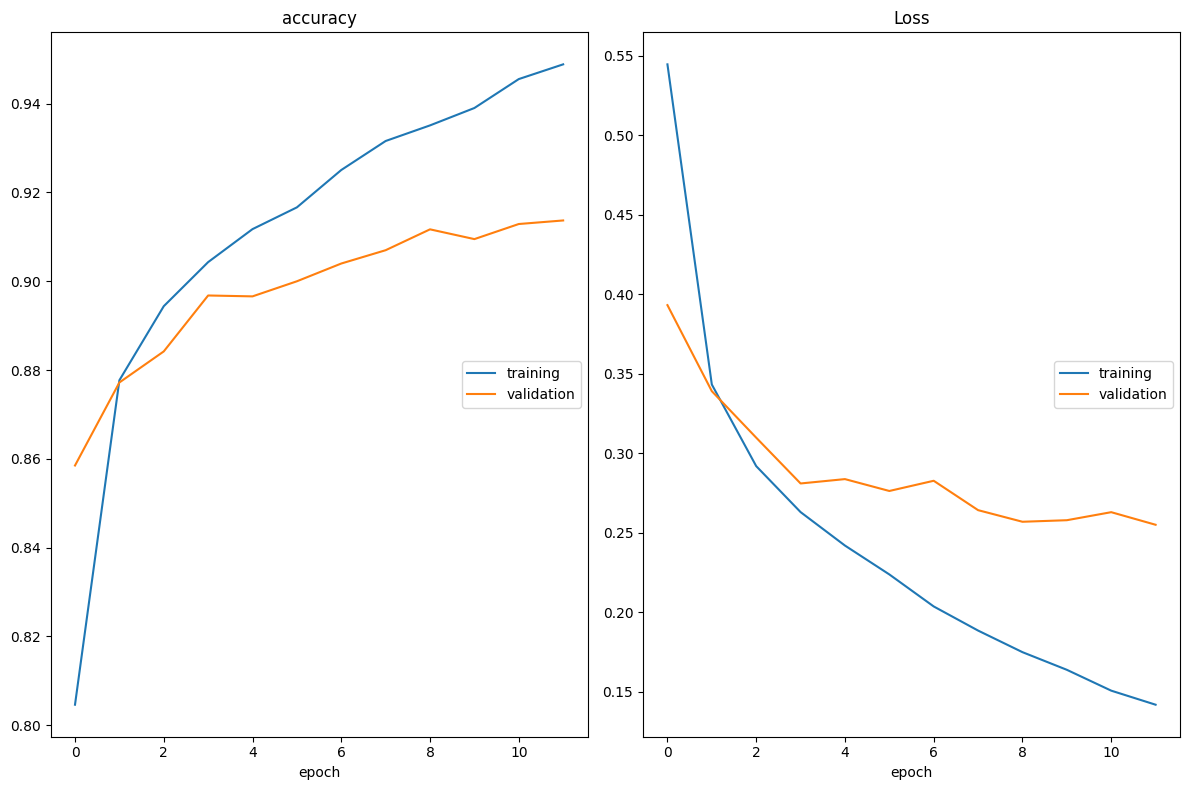

accuracy
	training         	 (min:    0.805, max:    0.949, cur:    0.949)
	validation       	 (min:    0.859, max:    0.914, cur:    0.914)
Loss
	training         	 (min:    0.142, max:    0.545, cur:    0.142)
	validation       	 (min:    0.255, max:    0.393, cur:    0.255)
938/938 [==============================] - 31s 33ms/step - loss: 0.1420 - accuracy: 0.9489 - val_loss: 0.2551 - val_accuracy: 0.9137


In [ ]:
plot_losses_0 = livelossplot.PlotLossesKeras()

history_0 = model_0.fit(trainX, trainY,
                        epochs=12,
                        batch_size=64,
                        callbacks=[plot_losses_0],
                        validation_data=(testX, testY))

In [ ]:
_, acc = model_0.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 91.370


In [ ]:
loss = history_0.history['loss']
accu = history_0.history['accuracy']
v_loss = history_0.history['val_loss']
v_accu = history_0.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 54.459%, accuracy: 80.462%,  val_loss: 39.321%, val_accuracy: 85.850%
epochs:  2, loss: 34.331%, accuracy: 87.770%,  val_loss: 33.911%, val_accuracy: 87.720%
epochs:  3, loss: 29.199%, accuracy: 89.438%,  val_loss: 30.988%, val_accuracy: 88.420%
epochs:  4, loss: 26.309%, accuracy: 90.432%,  val_loss: 28.109%, val_accuracy: 89.680%
epochs:  5, loss: 24.205%, accuracy: 91.175%,  val_loss: 28.383%, val_accuracy: 89.660%
epochs:  6, loss: 22.389%, accuracy: 91.665%,  val_loss: 27.636%, val_accuracy: 90.000%
epochs:  7, loss: 20.376%, accuracy: 92.507%,  val_loss: 28.278%, val_accuracy: 90.400%
epochs:  8, loss: 18.860%, accuracy: 93.160%,  val_loss: 26.431%, val_accuracy: 90.700%
epochs:  9, loss: 17.503%, accuracy: 93.512%,  val_loss: 25.701%, val_accuracy: 91.170%
epochs: 10, loss: 16.393%, accuracy: 93.903%,  val_loss: 25.798%, val_accuracy: 90.950%
epochs: 11, loss: 15.082%, accuracy: 94.555%,  val_loss: 26.303%, val_accuracy: 91.290%
epochs: 12, loss: 14.199%, accur

In [ ]:
pred_0 = model_0.predict(testX)

313/313 [==============================] - 3s 8ms/step


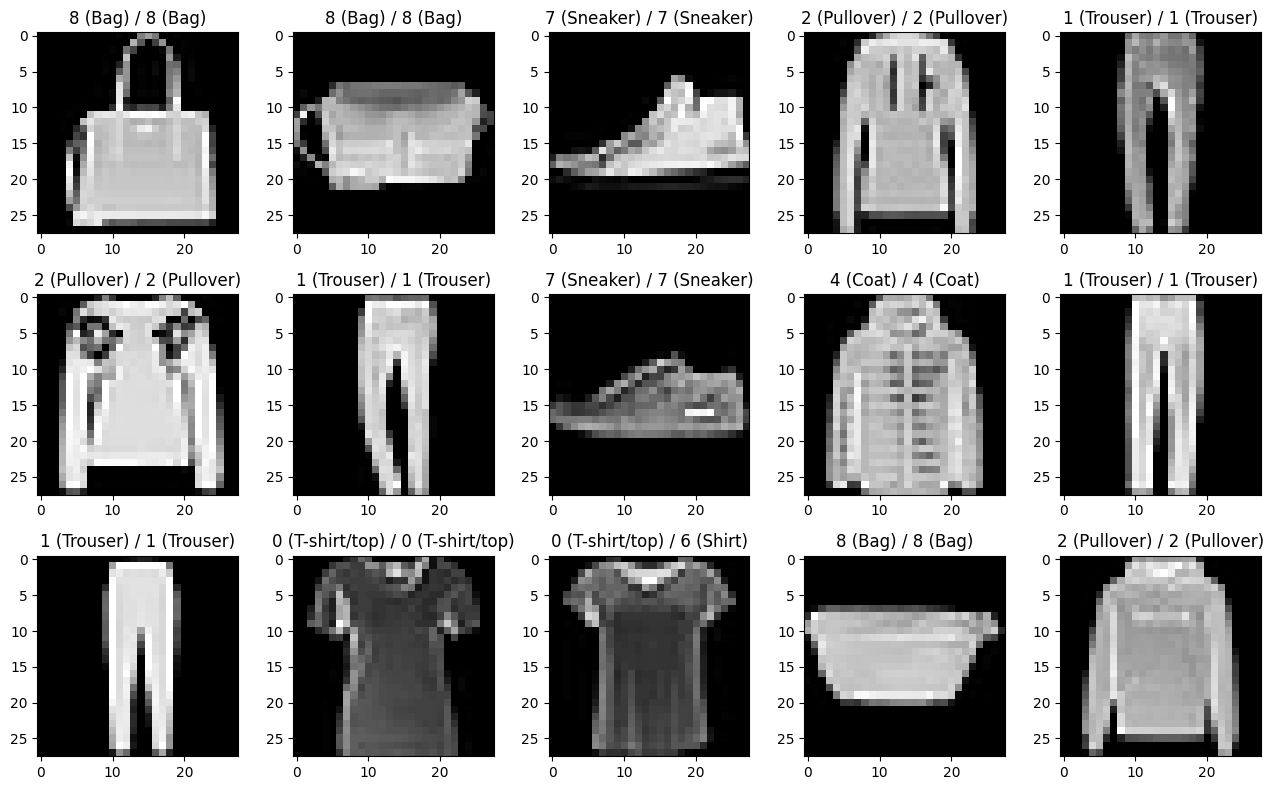

In [ ]:
display_some_examples(testX, testY, pred_0, label_name=label_name)

### Проста згорткова нейромережа з 1 згортковим шаром. Оптимізатор "Adam".


In [ ]:
model_0a = define_model(opt_name='Adam', learning_rate = 0.001)

optimizer: Adam, learning_rate: 0.001


In [ ]:
model_0a.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 5408)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               692352    
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

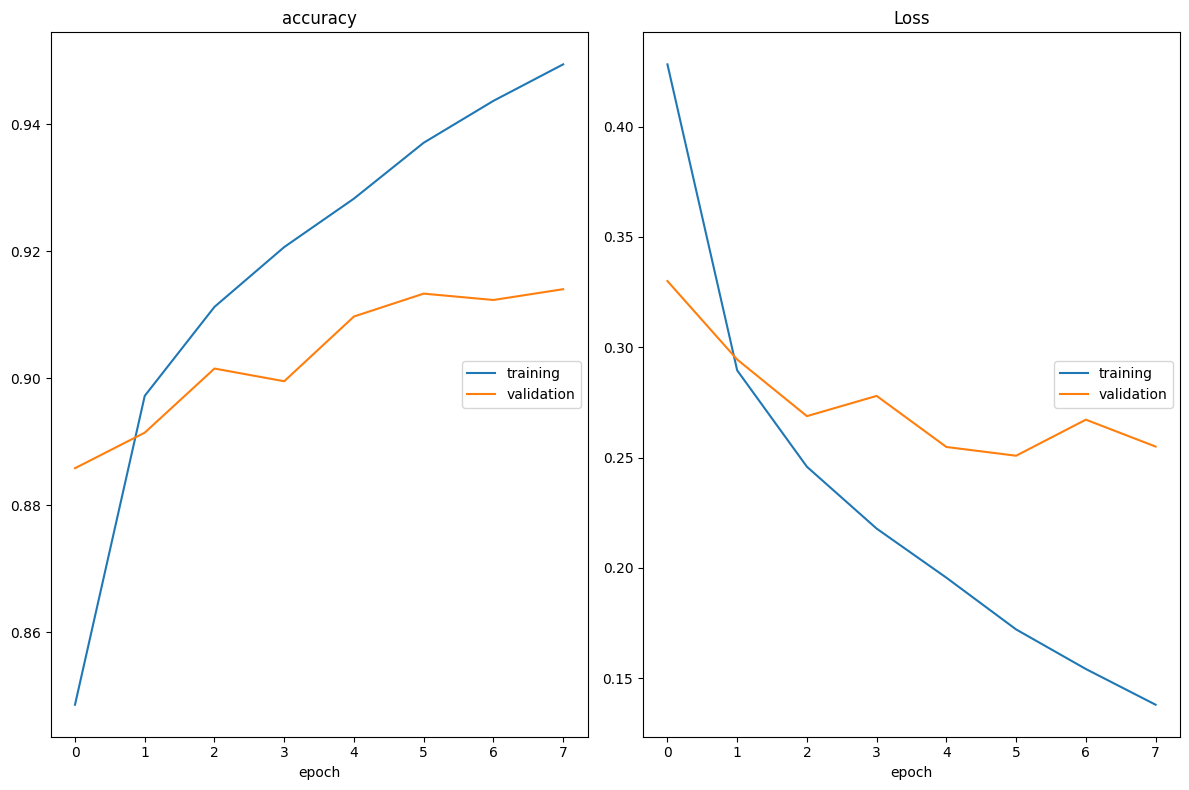

accuracy
	training         	 (min:    0.849, max:    0.949, cur:    0.949)
	validation       	 (min:    0.886, max:    0.914, cur:    0.914)
Loss
	training         	 (min:    0.138, max:    0.428, cur:    0.138)
	validation       	 (min:    0.251, max:    0.330, cur:    0.255)
938/938 [==============================] - 30s 32ms/step - loss: 0.1380 - accuracy: 0.9494 - val_loss: 0.2550 - val_accuracy: 0.9140


In [ ]:
plot_losses_0a = livelossplot.PlotLossesKeras()

history_0a = model_0a.fit(trainX, trainY,
                          epochs=8,
                          batch_size=64,
                          callbacks=[plot_losses_0a],
                          validation_data=(testX, testY))

In [ ]:
_, acc = model_0a.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 91.400


In [ ]:
loss = history_0a.history['loss']
accu = history_0a.history['accuracy']
v_loss = history_0a.history['val_loss']
v_accu = history_0a.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 42.824%, accuracy: 84.855%,  val_loss: 33.001%, val_accuracy: 88.580%
epochs:  2, loss: 28.953%, accuracy: 89.720%,  val_loss: 29.444%, val_accuracy: 89.140%
epochs:  3, loss: 24.584%, accuracy: 91.122%,  val_loss: 26.878%, val_accuracy: 90.150%
epochs:  4, loss: 21.780%, accuracy: 92.063%,  val_loss: 27.795%, val_accuracy: 89.950%
epochs:  5, loss: 19.555%, accuracy: 92.827%,  val_loss: 25.480%, val_accuracy: 90.970%
epochs:  6, loss: 17.210%, accuracy: 93.707%,  val_loss: 25.083%, val_accuracy: 91.330%
epochs:  7, loss: 15.416%, accuracy: 94.367%,  val_loss: 26.718%, val_accuracy: 91.230%
epochs:  8, loss: 13.797%, accuracy: 94.942%,  val_loss: 25.499%, val_accuracy: 91.400%


In [ ]:
pred_0a = model_0a.predict(testX)

313/313 [==============================] - 3s 9ms/step


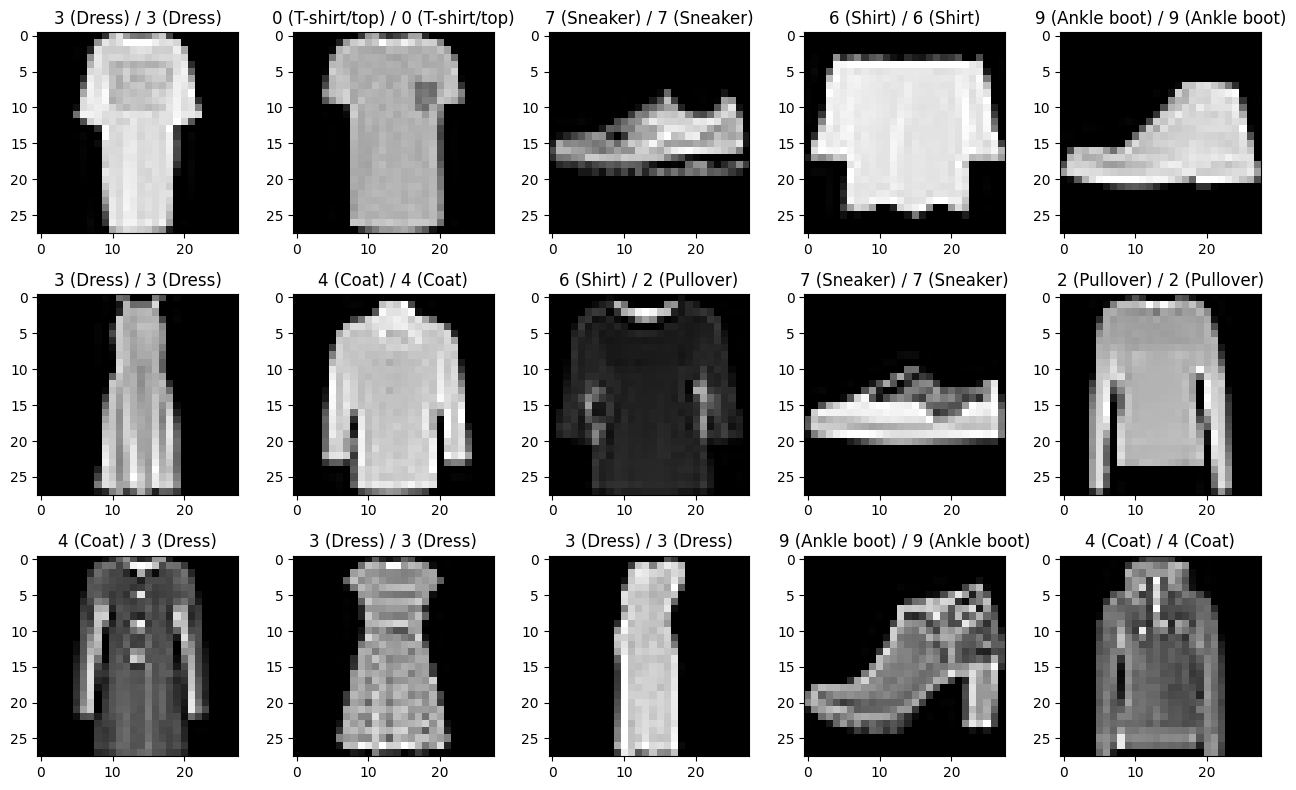

In [ ]:
display_some_examples(testX, testY, pred_0a, label_name=label_name)

### Більш розвинута згорткова нейромережа з 3-ма згортковими шарами. Оптимізатор "Adam".

In [ ]:
#define_model(opt_name: str = 'SGD', learning_rate: float = 0.01, n_conv: int = 1, n_drop: int = 0)
model_1 = define_model(opt_name='Adam', learning_rate = 0.001, n_conv = 3, n_drop = 2)

optimizer: Adam, learning_rate: 0.001


In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                 

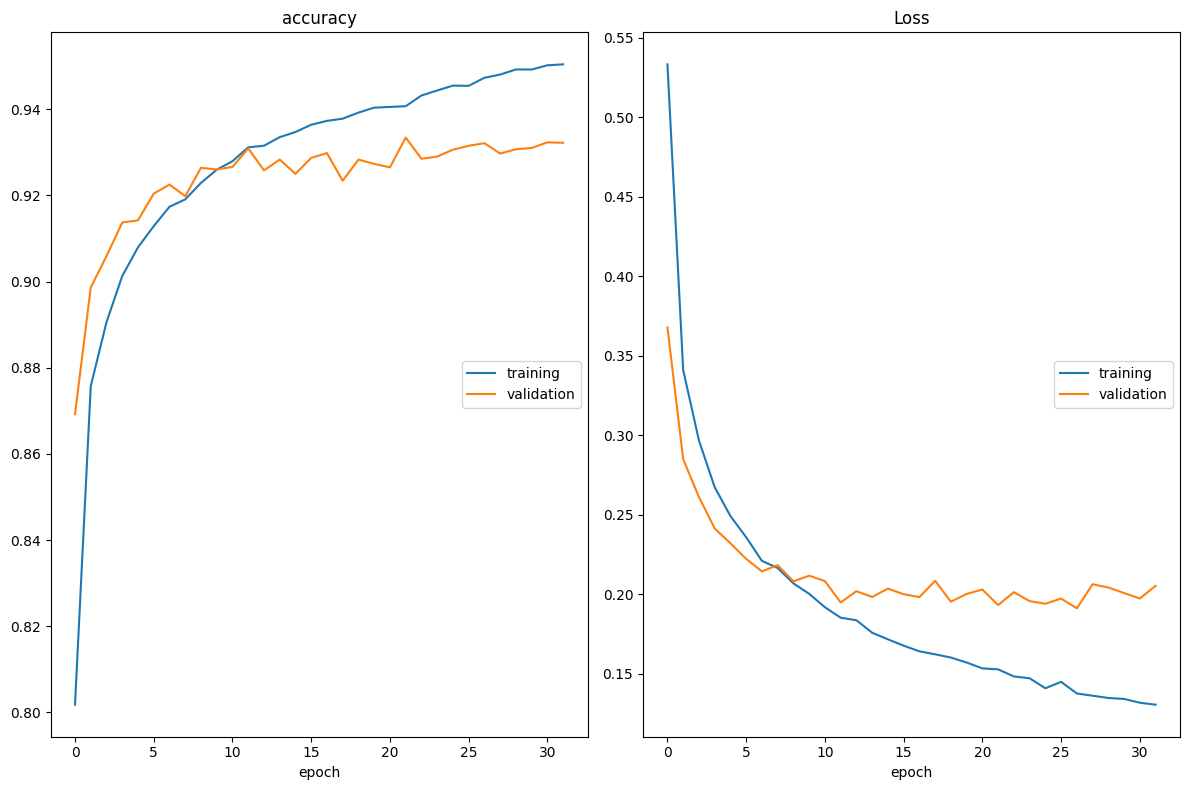

accuracy
	training         	 (min:    0.802, max:    0.950, cur:    0.950)
	validation       	 (min:    0.869, max:    0.933, cur:    0.932)
Loss
	training         	 (min:    0.131, max:    0.533, cur:    0.131)
	validation       	 (min:    0.191, max:    0.368, cur:    0.205)
938/938 [==============================] - 214s 228ms/step - loss: 0.1307 - accuracy: 0.9504 - val_loss: 0.2054 - val_accuracy: 0.9322


In [ ]:
plot_losses_1 = livelossplot.PlotLossesKeras()

history_1 = model_1.fit(trainX, trainY,
                        epochs=32,
                        batch_size=64,
                        callbacks=[plot_losses_1],
                        validation_data=(testX, testY))

In [ ]:
_, acc = model_1.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 93.220


In [ ]:
loss = history_1.history['loss']
accu = history_1.history['accuracy']
v_loss = history_1.history['val_loss']
v_accu = history_1.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 53.313%, accuracy: 80.180%,  val_loss: 36.776%, val_accuracy: 86.920%
epochs:  2, loss: 34.098%, accuracy: 87.572%,  val_loss: 28.498%, val_accuracy: 89.860%
epochs:  3, loss: 29.678%, accuracy: 89.057%,  val_loss: 26.120%, val_accuracy: 90.590%
epochs:  4, loss: 26.737%, accuracy: 90.128%,  val_loss: 24.144%, val_accuracy: 91.370%
epochs:  5, loss: 24.928%, accuracy: 90.793%,  val_loss: 23.211%, val_accuracy: 91.420%
epochs:  6, loss: 23.593%, accuracy: 91.285%,  val_loss: 22.235%, val_accuracy: 92.040%
epochs:  7, loss: 22.109%, accuracy: 91.735%,  val_loss: 21.447%, val_accuracy: 92.250%
epochs:  8, loss: 21.659%, accuracy: 91.907%,  val_loss: 21.838%, val_accuracy: 91.980%
epochs:  9, loss: 20.695%, accuracy: 92.288%,  val_loss: 20.822%, val_accuracy: 92.640%
epochs: 10, loss: 20.037%, accuracy: 92.595%,  val_loss: 21.180%, val_accuracy: 92.600%
epochs: 11, loss: 19.196%, accuracy: 92.792%,  val_loss: 20.838%, val_accuracy: 92.660%
epochs: 12, loss: 18.535%, accur

In [ ]:
pred_1 = model_1.predict(testX)

313/313 [==============================] - 9s 29ms/step


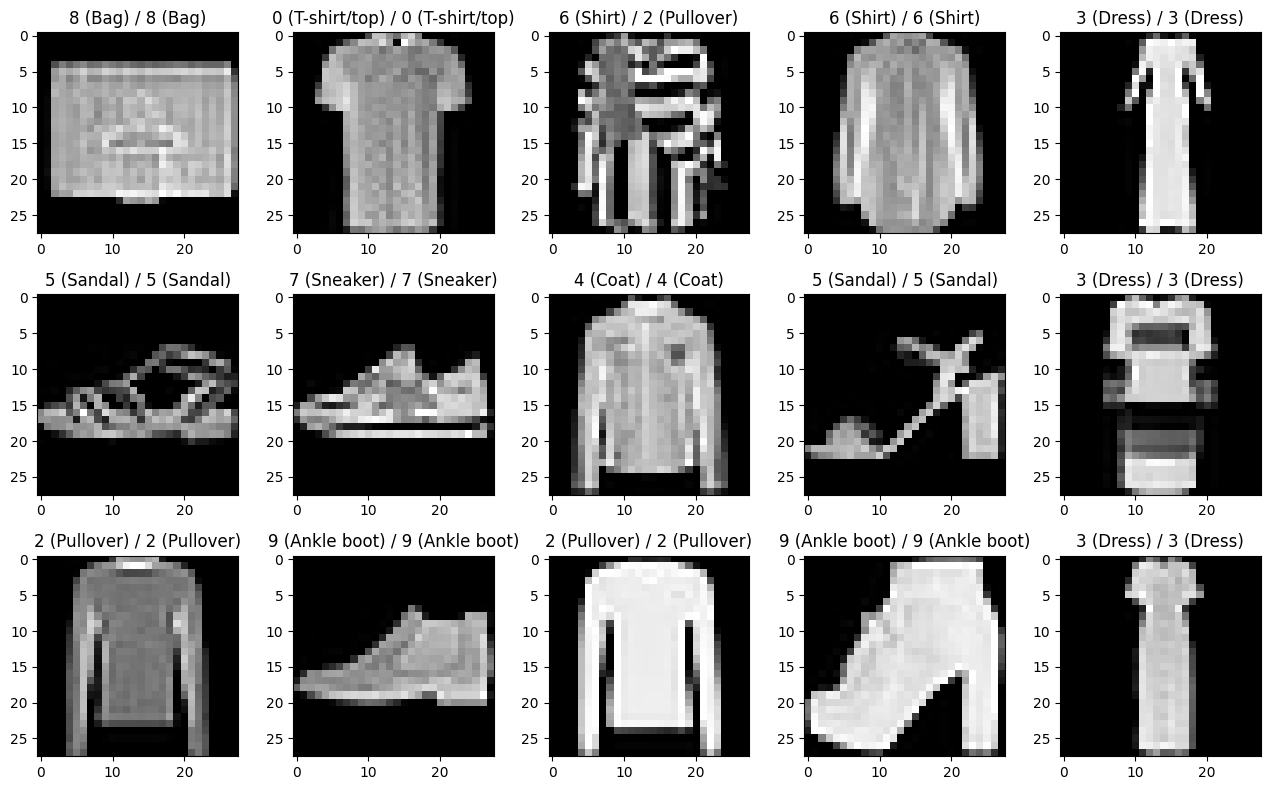

In [ ]:
display_some_examples(testX, testY, pred_1, label_name=label_name)

## Проста згорткова нейромережа з 1 згортковим шаром.
#### Оптимізатор "SGD", learning_rate: 0.01
Досягнута точність 91.37%  
## Проста згорткова нейромережа з 1 згортковим шаром.
#### Оптимізатор "Adam", learning_rate: 0.001
Досягнута точність 91.40%  
## Більш розвинута згорткова нейромережа з 3-ма згортковими шарами.
#### Оптимізатор "Adam", learning_rate: 0.001
Досягнута точність 93.22%

